# Ringed planetary transit code demo

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from time import time
import warnings

# my code
import ringed_planet_transit as rpt
print("rpt version: {:s}".format(rpt.__version__))

# Mandel & Agol (2002) transit code implemented by PSLS
from transit import occultquad

rpt version: 0.1


## Notes

### Existing tools / resources
#### PSLS
PLATO Solar-like Light-curve Simulator<br>
https://sites.lesia.obspm.fr/psls/<br>
https://pypi.org/project/psls/<br>
https://www.aanda.org/articles/aa/pdf/2019/04/aa34822-18.pdf<br>
https://sites.lesia.obspm.fr/psls/files/2020/06/PSLS.pdf<br>
Implements Mandel & Agol (2002) transit modelling. Would benefit from a more versatile occultation modelling method to incorporate comets, rings, moons, etc. Nicely implements realistic PLATO noise sources though, including stellar surface effects.<nb>
Exomoons are a more complex dynamical system but I suspect there may be an analytic form for their transit depth given orbital position so I'll ignore them for now.

#### SOAP3.0
https://arxiv.org/pdf/1709.06443.pdf<br>
fits only completely opaque rings

#### twobody
https://github.com/adrn/TwoBody<br>
useful to implement two body orbital dynamics if I don't get time.

#### bpic comit fit
This beta pic exocomit transit fitting effort in Tess data.<br>
https://github.com/sebastian-zieba/betaPic_comet/blob/master/modelling/exocomet_fit.ipynb
    
### Other relevant works
https://ui.adsabs.harvard.edu/abs/2015ApJ...807...65S/abstract<br>
https://ui.adsabs.harvard.edu/abs/2019AJ....157...42S/abstract -- https://github.com/esandford/EightBitTransit

## Light curve sim testing

In [2]:
help(rpt.build_ringed_occulter)

Help on function build_ringed_occulter in module ringed_planet_transit:

build_ringed_occulter(rings=None, gamma=0.0, Ngrid=100, super_sample_factor=10, full_output=False)
    Build a greyscale transparency image of a ringed occulter.
    
    Parameters:
    rings : N, list of 3, tuples; optional
        The list of N rings to include in the model. Each list element is a 3
        component tuple of (i_r, o_r, T), where i_r and o_r are the ring inner
        and outer radii in units of planet radii and T is the ring transparency
        in the range [0,1]. T=0 is fully opaque, T=1 is completely transparent.
        (Default None, i.e. no rings.)
    gamma : float; optional
        Inclination angle relative to the line of sight to the observer in
        radians. (Default 0.0.)
    Ngrid : int; optional
        The number of grid points (or pixels if you like) in the occulter image
        along the major axis per planet radius. The actual number of grid points
        returned depend

In [3]:
# list of rings to include
# parameters are (inner rad, outer rad, transparency)
rings = [
    (1.1,1.3,0.01),
    (1.4,1.6,0.2),
    (1.8,2.2,0.1),
    (3.6,5.4,0.5),
]
t0 = time()
p,x,y,A = rpt.build_ringed_occulter(rings=rings, gamma=np.pi/32, Ngrid=20, full_output=True)
print("built transparency model in {:.3f} ms".format((time()-t0)*1000.))

built transparency model in 24.498 ms


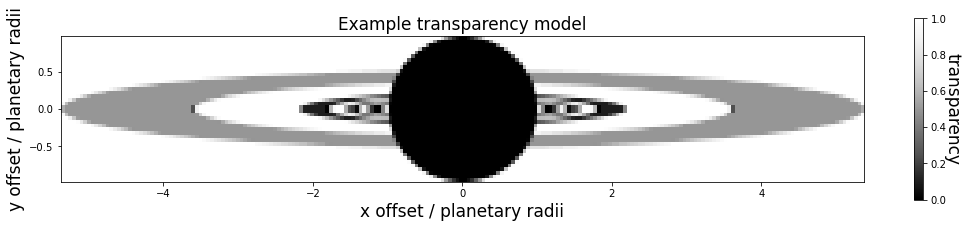

In [4]:
shp = np.array(p.shape)
plt.figure(figsize=(18*shp/shp.max()))
plt.imshow(p.T, origin='lower left', cmap='Greys_r', 
           extent=[x.min(),x.max(),y.min(),y.max()])
cbar = plt.colorbar()
plt.xlabel("x offset / planetary radii", fontsize=17)
plt.ylabel("y offset / planetary radii", fontsize=17)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("transparency", rotation=270, fontsize=17)
plt.title("Example transparency model", fontsize=17)
plt.show()

## Limb darkened star quick test

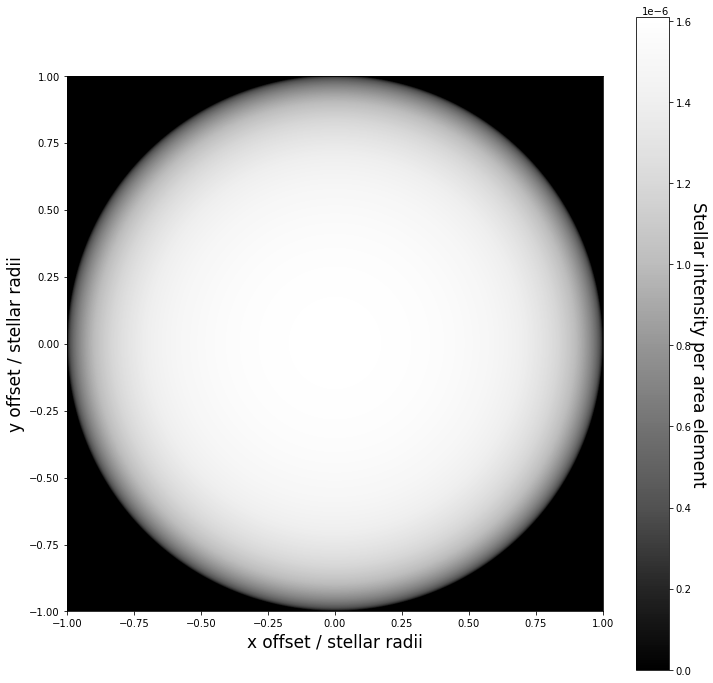

In [5]:
# grid over which to evaluate stellar intensity
Ngrid_star = 1000
xpts, ypts = np.meshgrid(*[np.linspace(-1,1,Ngrid_star)]*2)
# area of each grid element
A_elem = (2/Ngrid_star)**2

# quadratic limb darkening parameters from the psls example
a, b = 0.25, 0.75

# evaluate intensity
I = rpt.quad_limb_dark(np.sqrt(xpts**2+ypts**2), a, b) * A_elem

# plot the image
shp = np.array(I.shape)
figsize = 12*shp/shp.max()
plt.figure(figsize=(figsize))
plt.imshow(I.T, origin='lower left', extent=[-1,1,-1,1], cmap='Greys_r')
plt.xlabel("x offset / stellar radii", fontsize=17)
plt.ylabel("y offset / stellar radii", fontsize=17)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Stellar intensity per area element", rotation=270, fontsize=17)
plt.show()

## Test of occultation light curve modelling

In [6]:
help(rpt.occult_star)

Help on function occult_star in module ringed_planet_transit:

occult_star(transparency_mask, planet_radius, offset_x, offset_y, obliquity, ld_params)
    Produce a stellar flux sequence during occultation by an object with a
    given transparency mask.
    
    Parameters:
    transparency_mask : tuple of len=4
        A tuple of the transparency values, x positions and y positions of each
        transparency element, and the area of each transparency element in units
        of planetary radii squared. This tuple is as returned by the
        build_ringed_occulter function.
    planet_radius : float
        The radius of the planet as a fraction of the radius of the star.
    offset_x : ndarray of size N
        This is an array of N positional offsets of the planet centre from the
        planet position at the instant of inferior conjunction in units of
        stellar radii. In contrast to standard spherical planet transit
        modelling the sign on offset_x is important wher

In [7]:
# load an example occulter...
invader = 1-image.imread('data/invader.png')
_x,_y = np.meshgrid(np.arange(invader.shape[1]), np.arange(invader.shape[0]))
sel = invader.copy()<1
inv,_x,_y = map(lambda _a:_a[sel].flatten().astype(np.float64), [invader,_x,_y])
A = 1/inv.size
rad = np.max(np.sqrt(_x**2+_y**2))
_x, _y = _x/rad, _y/rad
_y -= _y.mean()
_x -= _x.mean()

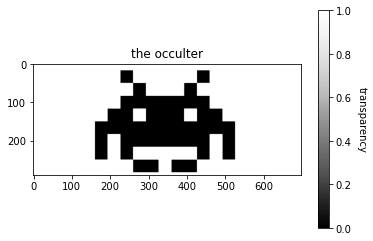

In [8]:
plt.imshow(invader, cmap='Greys_r')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("transparency", rotation=270)
plt.title("the occulter")
plt.show()

Simulate a transit of a solar-like star, where the occulter (/invader) is 10% of the angular diameter of the star.

In [9]:
x_offset = np.linspace(-2,2,1000)
f = rpt.occult_star((inv,_x,_y,A),0.1,x_offset,0.0,0.0,[0.25, 0.75])

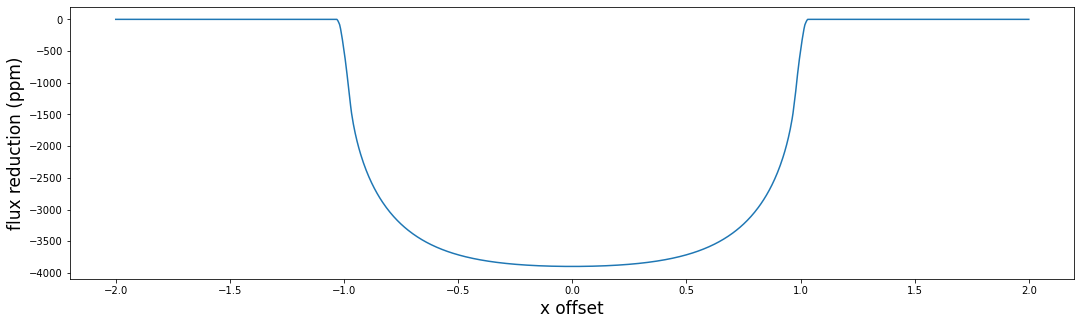

In [10]:
plt.figure(figsize=(18,5))
plt.plot(x_offset, (f-1)*1E6)
plt.xlabel("x offset", fontsize=17)
plt.ylabel("flux reduction (ppm)", fontsize=17)
plt.show()

That looks surprisingly similar to a normal exoplanet transit. (_should we be worried??_)

## A simple ringed vs. non-ringed planet transit

In [11]:
# model parameters
# r_planet / r_star
planet_scale = 0.05 
# positional offset at inferior conjunction
y_offset = -0.5
# positions along orbit relative to position at inferior conjunction
x_offsets = np.linspace(-2,2,1000)

# rings to include in the ringed model
rings = [
    (1.1,1.3,0.01),
    (1.4,1.6,0.2),
    (1.8,2.2,0.1),
    (3.6,5.4,0.5),
]

# build ringed and non-ringed transparency masks
kwargs = {'Ngrid':20, 'gamma':np.pi/32}
ringed = rpt.build_ringed_occulter(rings=rings, **kwargs)
nonringed = rpt.build_ringed_occulter(rings=None, **kwargs)

# generate the transit light curves
# ringed
f_ringed = rpt.occult_star(ringed, planet_scale, x_offsets, y_offset, 0.0, [0.25, 0.75])
# non-ringed
f_nonringed = rpt.occult_star(nonringed, planet_scale, x_offsets, y_offset, 0.0, [0.25, 0.75])

# run the Mandel & Agol (2002) code as implemented in PSLS
z = np.sqrt(x_offsets**2+y_offset**2)
f_MA02 = occultquad(z, planet_scale, [a,b])

/home/lsmith/Dropbox/Work/plato/PLATO_ring_sim/transit.py:802: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))


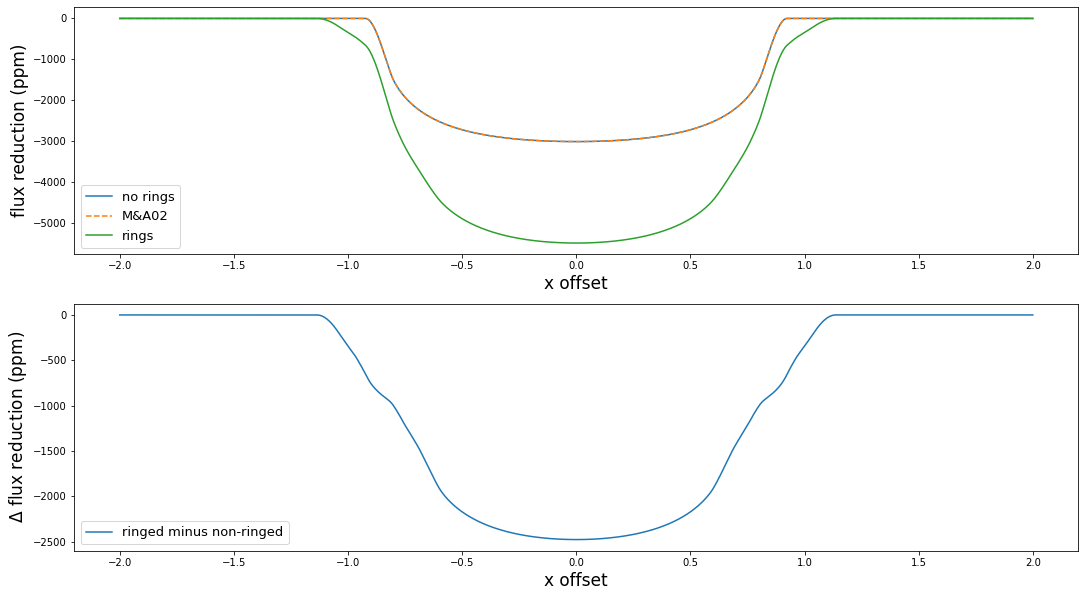

In [12]:
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(x_offsets, (f_nonringed-1)*1E6, label='no rings', zorder=10)
plt.plot(x_offsets, (f_MA02-1)*1E6, label='M&A02', ls='--', zorder=20)
plt.plot(x_offsets, (f_ringed-1)*1E6, label='rings', zorder=30)
plt.xlabel("x offset", fontsize=17)
plt.ylabel("flux reduction (ppm)", fontsize=17)
plt.legend(fontsize=13)
plt.subplot(212)
plt.plot(x_offsets, 1E6*(f_ringed-f_nonringed), label='ringed minus non-ringed')
plt.xlabel("x offset", fontsize=17)
plt.ylabel(r"$\Delta$ flux reduction (ppm)", fontsize=17)
plt.legend(fontsize=13)
plt.show()

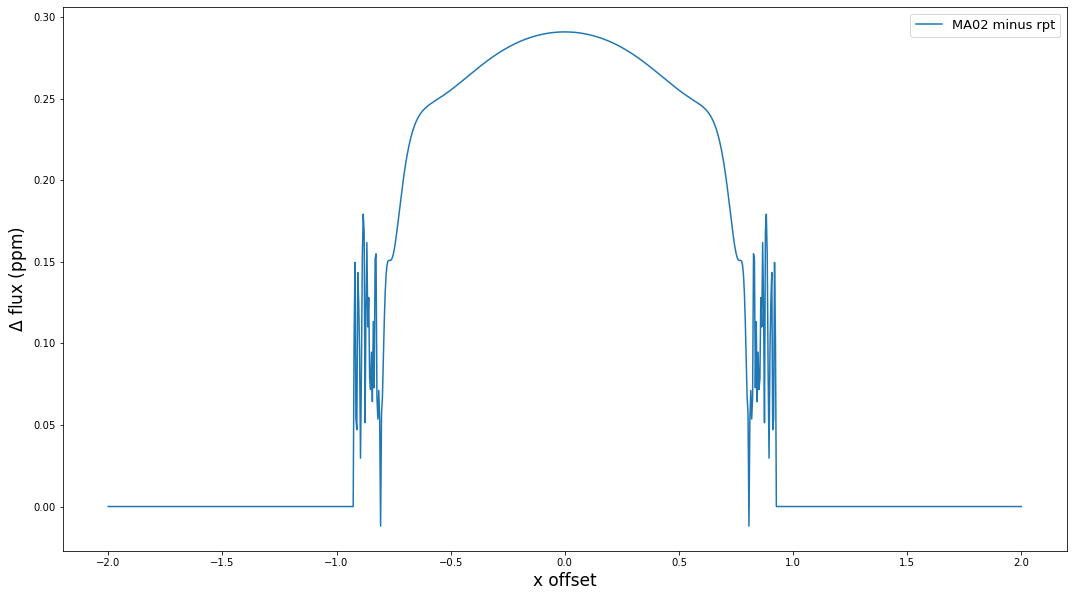

In [13]:
plt.figure(figsize=(18,10))
plt.plot(x_offsets, (f_MA02-f_nonringed)*1E6, label='MA02 minus rpt')
plt.ylabel(r"$\Delta$ flux (ppm)", fontsize=17)
plt.xlabel("x offset", fontsize=17)
plt.legend(fontsize=13)
plt.show()

The difference vs Mandel & Agol (2002) of the equivalent rpt non-ringed planet model is better than 1ppm. By contrast, for PLATO:

>The expected noise level for stars with visual magnitudes of less than 11 is 34 ppm per hour, and for stars brighter than 13th mag the noise is expected to be below 80 ppm per hour.

-- Marcos-Arenal, P. et al. (2014); The PLATO Simulator: modelling of high-precision high-cadence space-based imaging; 2014A&A...566A..92M

## A test of grid sizing errors

Checking the difference between light curve modelling output for low resolution grids vs. a high resolution grid.

In [14]:
# model parameters
# r_planet / r_star
planet_scale = 0.05 
# positional offset at inferior conjunction
y_offset = -0.5
# positions along orbit relative to position at inferior conjunction
x_offsets = np.linspace(-2,2,200)

# the rings to model
rings = [
    (1.1,1.3,0.01),
    (1.4,1.6,0.2),
    (1.8,2.2,0.1),
    (3.6,5.4,0.5),
]

# grid sizes to test
grid_tests = [2,4,8,20,40,80,200,400]

# somewhere to put the output
rfs = []
ms_grid = []
ms_lc = []

for Ngrid in grid_tests:
    print("{:d}".format(Ngrid), end='... ')
    # ringed grid
    t0 = time()
    _ro = rpt.build_ringed_occulter(rings=rings, gamma=np.pi/32, Ngrid=Ngrid)
    t1 = time()
    # model the light curve
    rf = rpt.occult_star(_ro, planet_scale, x_offsets, y_offset, 0.0, [0.25, 0.75])
    t2 = time()
    # add fluxes relative to baseline and run times to the pile
    rfs += [rf.copy()]
    ms_grid += [(t1-t0)*1000.]
    ms_lc += [(t2-t1)*1000./x_offsets.size]
print("done")

2... 4... 8... 20... 40... 80... 200... 400... done


number of grid points,
time to generate grid (milliseconds),
time to evaluate one light curve point (nanoseconds),
log10 maximum relative difference vs highest resolution grid

Ngrid | t grid ms | t lcp ns | max log err
------|-----------|----------|------------
    2 |       3.8 |      8.4 |       -4.06
    4 |       5.8 |     10.3 |       -4.54
    8 |       9.3 |     36.1 |       -4.75
   20 |      19.7 |    220.9 |       -5.94
   40 |      38.6 |    802.1 |       -5.90
   80 |      78.5 |   3730.0 |       -6.56
  200 |     255.1 |  21095.4 |       -7.35
  400 |     781.2 |  85010.7 |        -inf


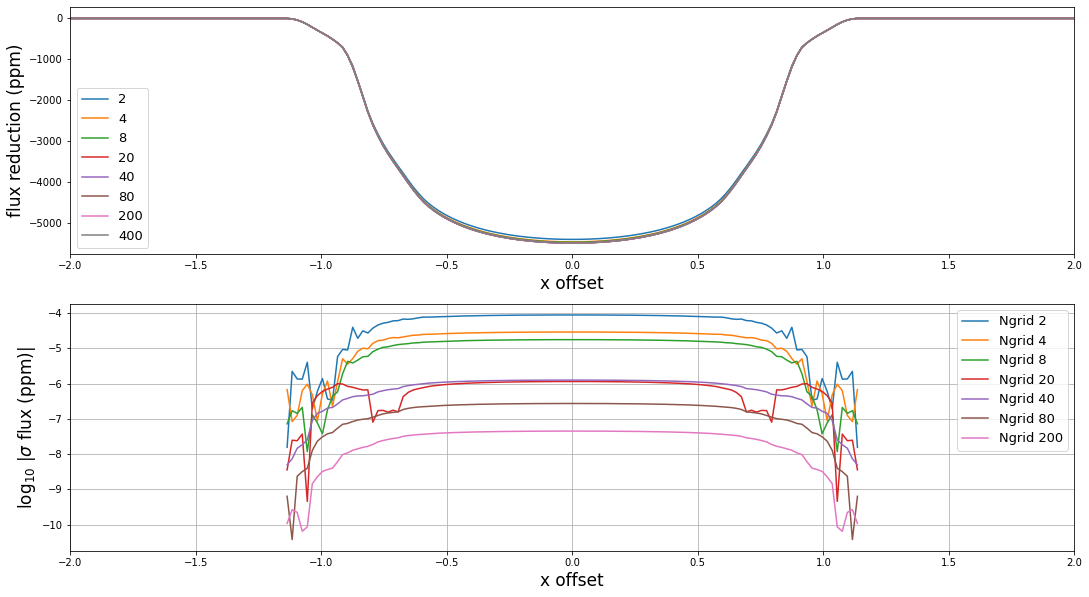

In [15]:
# open the figure
plt.figure(figsize=(18,10))

# plot transits
plt.subplot(211)
for n in range(len(grid_tests)):
    plt.plot(x_offsets, (rfs[n]-1)*1E6, label="{:d}".format(grid_tests[n]))
plt.legend(fontsize=13)
plt.xlabel("x offset", fontsize=17)
plt.ylabel("flux reduction (ppm)", fontsize=17)
plt.xlim(x_offsets.min(), x_offsets.max())

# now plot them relative to highest resolution
print("""\
number of grid points,
time to generate grid (milliseconds),
time to evaluate one light curve point (nanoseconds),
log10 maximum relative difference vs highest resolution grid

Ngrid | t grid ms | t lcp ns | max log err
------|-----------|----------|------------""")
plt.subplot(212)
for n in range(len(grid_tests)-1):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        logerr = np.log10(np.abs(rfs[-1]-rfs[n]))
    print("{:5d} | {:9.1f} | {:8.1f} | {:11.2f}".format(grid_tests[n], ms_grid[n], ms_lc[n]*1000., logerr.max()))
    plt.plot(x_offsets, logerr, 
             label="Ngrid {:d}".format(grid_tests[n]))
print("{:5d} | {:9.1f} | {:8.1f} |        -inf".format(grid_tests[-1], ms_grid[-1], ms_lc[-1]*1000.))
plt.legend(fontsize=13)
plt.xlabel("x offset", fontsize=17)
plt.ylabel(r"log$_{10}$ |$\sigma$ flux (ppm)|", fontsize=17)
plt.xlim(x_offsets.min(), x_offsets.max())
plt.grid()

plt.show()

With Ngrid in the low 10s I achieve ppm accuracy or better, and still reasonable compute times. Compute times could be reduced further by porting rpt.build_ringed_occulter and rpt.occult_star to c++.

## The impact of changing the obliquity

Simply out of curiosity.

In [16]:
# model parameters
# r_planet / r_star
planet_scale = 0.05 
# positional offset at inferior conjunction
y_offset = -0.5
# positions along orbit relative to position at inferior conjunction
x_offsets = np.linspace(-2,2,1000)

# the rings to model
rings = [
    (1.1,1.3,0.01),
    (1.4,1.6,0.2),
    (1.8,2.2,0.1),
    (3.6,5.4,0.5),
]

# obliquities to test
test_obliquities = np.arange(0.0, np.pi, np.pi/8)

# somewhere to put the output
rfs = []

for obq in test_obliquities:
    # ringed grid
    _ro = rpt.build_ringed_occulter(rings=rings, gamma=np.pi/32, Ngrid=20)
    # model the light curve
    rf = rpt.occult_star(_ro, planet_scale, x_offsets, y_offset, obq, [0.25, 0.75])
    # add fluxes relative to baseline to the pile
    rfs += [rf.copy()]

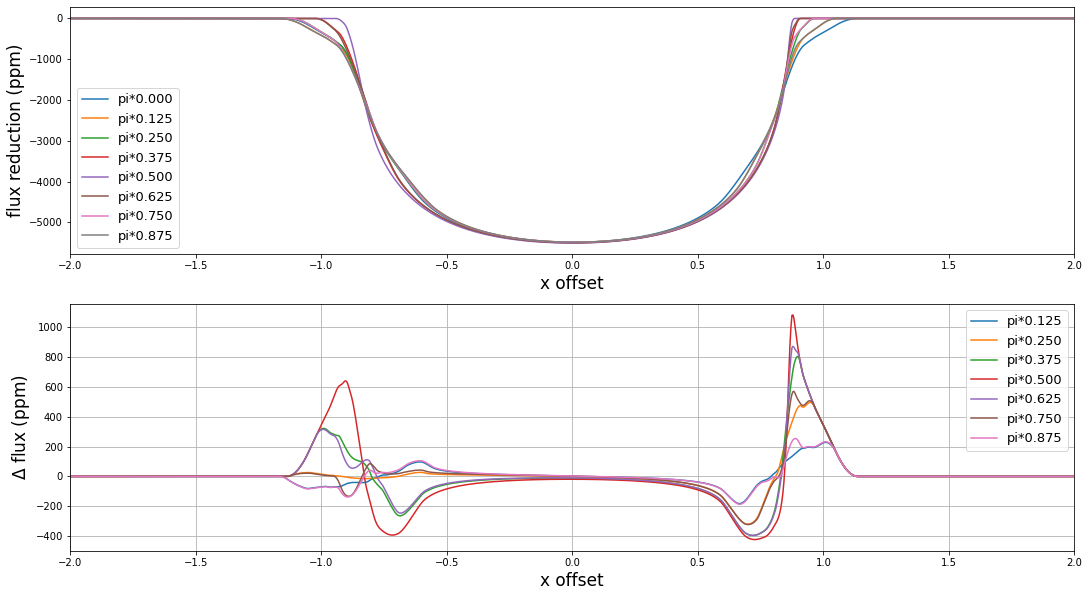

In [17]:
# open the figure
plt.figure(figsize=(18,10))

# plot transits
plt.subplot(211)
for n in range(len(test_obliquities)):
    plt.plot(x_offsets, (rfs[n]-1)*1E6, 
             label="pi*{:.3f}".format((test_obliquities[n]/np.pi)))
plt.legend(fontsize=13)
plt.xlabel("x offset", fontsize=17)
plt.ylabel("flux reduction (ppm)", fontsize=17)
plt.xlim(x_offsets.min(), x_offsets.max())

# plot transits relative to zero obliquity
plt.subplot(212)
for _n in range(len(test_obliquities)-1):
    n = _n+1
    plt.plot(x_offsets, (rfs[n]-rfs[0])*1E6, 
             label="pi*{:.3f}".format((test_obliquities[n]/np.pi)))
plt.legend(fontsize=13)
plt.xlabel("x offset", fontsize=17)
plt.ylabel("$\Delta$ flux (ppm)", fontsize=17)
plt.xlim(x_offsets.min(), x_offsets.max())
plt.grid()

plt.show()

These are pretty significant differences. With a large ring system it should be fairly easy to identify any planets who's ring systems are misaligned relative to the planetary orbital plane.

## final thoughts

* If varying los inclination of planetary disk, there might be no need to rebuild the entire grid. You can evaluate the planet and ring grids seperately. Changing gamma doesn't change the silhouette of the planet itself, only the axis ratio of the rings, so the ring grid can just be 'squashed' appropriately. This might not end up being much faster though (if it is at all) as you can no longer not build the part of the ring that is in front of or behind the planet.
* Here I am not modelling stellar light reflected off the planet and ring system, or the occultation of the planet by the star.
* Some interpolation and smoothing might help with model noise due to low Ngrid.